In [55]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count
from tqdm.notebook import tqdm_notebook

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

In [6]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [7]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [9]:
def available_actions(env):
    empty_spaces = env.getEmptySpaces()
    size = len(empty_spaces)
    return [env.int_from_action(empty_spaces[i]) for i in range(size)]

In [26]:
def epsilon_greedy(env, Q, epsilon = 0.1):
    available_acts = available_actions(env)
    size = len(available_acts)
    state = env.getState()[0]

    if state not in Q.keys():
        Q[state] = np.zeros(len(available_acts))
        
    if np.random.random() > epsilon:
        n_act = np.argmax(Q[state])
    else:
        n_act = np.random.choice(size)

    return n_act, available_acts[n_act]

In [34]:
def step(env,
         action,
         crosses,
         done):
    
    next_state, reward, done, _ = env.step(env.action_from_int(action))
    reward = crosses * reward

    return next_state, reward, done

In [57]:
def Q_learning_episode(strategy,
                       env,
                       Q, 
                       lr = 0.01,
                       gamma = 1.,
                       crosses = 1,
                       *args,
                       **kwargs):
    
    env.reset()
    done = False
    
    if env.curTurn != crosses:
        available_acts = available_actions(env)
        opponent_action = np.random.choice(available_acts)
        env.step(env.action_from_int(opponent_action))
        
    while True:
        state = env.getState()[0]
        q_action, action = strategy(env, Q, *args, **kwargs)


        _, reward, done = step(env, action, crosses, done)
        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            return reward

        available_acts = available_actions(env)
        opponent_action = np.random.choice(available_acts)
        next_state, reward, done = step(env, opponent_action, crosses, done)

        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            return reward
            
        next_state = next_state[0]
        if next_state in Q.keys():
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])
        else:
            available_acts = available_actions(env)
            Q[next_state] = np.zeros(len(available_acts))
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])

In [61]:
def Q_learning(strategy,
               env = TicTacToe(),
               n_games = 100000,
               verbose = True,
               check_point = 1000,
               crosses = 1,
               *args,
               **kwargs):
    
    Q = dict()
    game_rewards_mean = list()
    rewards = list()

    for i in tqdm_notebook(range(n_games)):
        R = Q_learning_episode(strategy, env, Q, crosses = crosses, *args, **kwargs)
        rewards.append(R)
        if (i % check_point == 0):
            if verbose:
                print("{}/{}".format(i + 1, n_games) + " avg rewards: {}".format(np.mean(rewards)))
            game_rewards_mean.append(np.mean(rewards))
            rewards = list()
    return Q, game_rewards_mean

In [62]:
n_games = 500
Q_crosses, rewards_crosses = Q_learning(epsilon_greedy, verbose = False, crosses = 1)

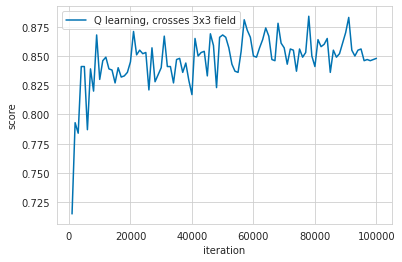

In [63]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label = 'Q learning, crosses 3x3 field')
plt.xlabel('iteration')
plt.ylabel('score')
plt.legend();